In [1]:
!pip install gurobipy
!pip install gosdt
!pip install gurobipy
!pip show gurobipy



import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import pathlib
import tree as miptree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from model.threshold_guess import compute_thresholds, cut
from model.gosdt import GOSDT
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
  
from sklearn import metrics
# import imblearn
# from imblearn.over_sampling import SMOTE
import datetime

%matplotlib inline

data = pd.read_csv("C:\\Users\\nirva\\Desktop\\LoanApprovalPrediction (1).csv")

Name: gurobipy
Version: 9.5.2
Summary: Python interface to Gurobi
Home-page: https://www.gurobi.com
Author: Gurobi Optimization, LLC
Author-email: 
License: Proprietary
Location: c:\users\nirva\anaconda3\lib\site-packages
Requires: 
Required-by: 


In [2]:
data.head(10)


Loan_ID Gender Married  Dependents     Education Self_Employed  \
0  LP001002   Male      No         0.0      Graduate            No   
1  LP001003   Male     Yes         1.0      Graduate            No   
2  LP001005   Male     Yes         0.0      Graduate           Yes   
3  LP001006   Male     Yes         0.0  Not Graduate            No   
4  LP001008   Male      No         0.0      Graduate            No   
5  LP001011   Male     Yes         2.0      Graduate           Yes   
6  LP001013   Male     Yes         0.0  Not Graduate            No   
7  LP001014   Male     Yes         3.0      Graduate            No   
8  LP001018   Male     Yes         2.0      Graduate            No   
9  LP001020   Male     Yes         1.0      Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5849                0.0         NaN             360.0   
1             4583             1508.0       128.0             360.0   
2             3000                0.0        66.0             360.0   
3             2583             2358.0       120.0             360.0   
4             6000                0.0       141.0             360.0   
5             5417             4196.0       267.0             360.0   
6             2333             1516.0        95.0             360.0   
7             3036             2504.0       158.0             360.0   
8             4006             1526.0       168.0             360.0   
9            12841            10968.0       349.0             360.0   

   Credit_History Property_Area Loan_Status  
0             1.0         Urban           Y  
1             1.0         Rural           N  
2             1.0         Urban           Y  
3             1.0         Urban           Y  
4             1.0         Urban           Y  
5             1.0         Urban           Y  
6             1.0         Urban           Y  
7             0.0     Semiurban           N  
8             1.0         Urban           Y  
9             1.0     Semiurban           N

In [3]:
obj = (data.dtypes == 'object')
print("Categorical variables:",len(list(obj[obj].index)))

Categorical variables: 7


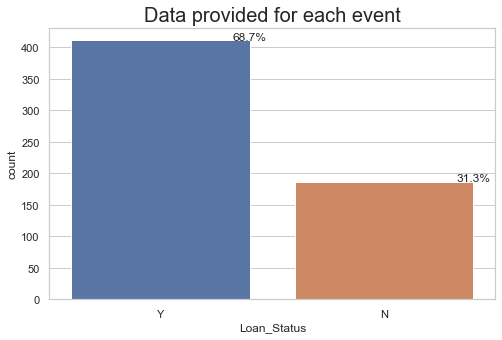

In [4]:
#Loan Status count graph
sns.set(style="whitegrid")
plt.figure(figsize=(8,5))
total = float(len(data))
ax = sns.countplot(x="Loan_Status", data=data)
plt.title('Data provided for each event', fontsize=20)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='center')
plt.show()

In [5]:
# Dropping Loan_ID column
data.drop(['Loan_ID'],axis=1,inplace=True)

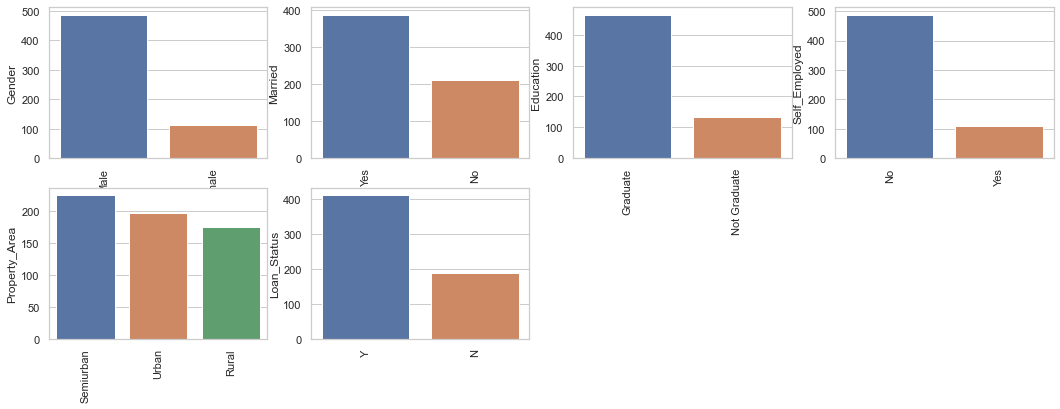

In [6]:
obj = (data.dtypes == 'object')
object_cols = list(obj[obj].index)
plt.figure(figsize=(18,36))
index = 1
  
for col in object_cols:
  y = data[col].value_counts()
  plt.subplot(11,4,index)
  plt.xticks(rotation=90)
  sns.barplot(x=list(y.index), y=y)
  index +=1

In [7]:
# Import label encoder
from sklearn import preprocessing
    
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
obj = (data.dtypes == 'object')
for col in list(obj[obj].index):
  data[col] = label_encoder.fit_transform(data[col])

In [8]:
data

Gender  Married  Dependents  Education  Self_Employed  ApplicantIncome  \
0         1        0         0.0          0              0             5849   
1         1        1         1.0          0              0             4583   
2         1        1         0.0          0              1             3000   
3         1        1         0.0          1              0             2583   
4         1        0         0.0          0              0             6000   
..      ...      ...         ...        ...            ...              ...   
593       0        0         0.0          0              0             2900   
594       1        1         3.0          0              0             4106   
595       1        1         1.0          0              0             8072   
596       1        1         2.0          0              0             7583   
597       0        0         0.0          0              1             4583   

     CoapplicantIncome  LoanAmount  Loan_Amount_Term  Credit_History  \
0                  0.0         NaN             360.0             1.0   
1               1508.0       128.0             360.0             1.0   
2                  0.0        66.0             360.0             1.0   
3               2358.0       120.0             360.0             1.0   
4                  0.0       141.0             360.0             1.0   
..                 ...         ...               ...             ...   
593                0.0        71.0             360.0             1.0   
594                0.0        40.0             180.0             1.0   
595              240.0       253.0             360.0             1.0   
596                0.0       187.0             360.0             1.0   
597                0.0       133.0             360.0             0.0   

     Property_Area  Loan_Status  
0                2            1  
1                0            0  
2                2            1  
3                2            1  
4                2            1  
..             ...          ...  
593              0            1  
594              0            1  
595              2            1  
596              2            1  
597              1            0  

[598 rows x 12 columns]

In [9]:
# To find the number of columns with 
# datatype==object
obj = (data.dtypes == 'object')
print("Categorical variables:",len(list(obj[obj].index)))

Categorical variables: 0


<AxesSubplot:>

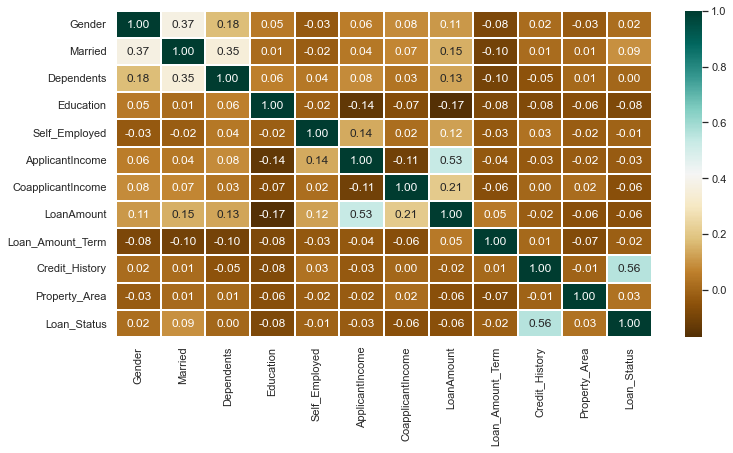

In [10]:
plt.figure(figsize=(12,6))
  
sns.heatmap(data.corr(),cmap='BrBG',fmt='.2f',
            linewidths=2,annot=True)

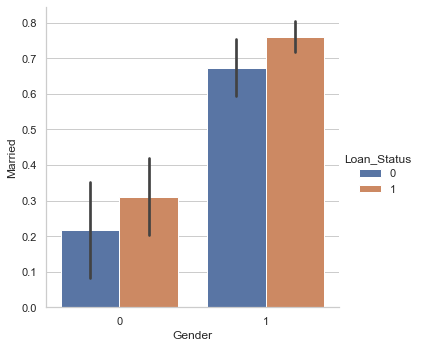

In [11]:
sns.catplot(x="Gender", y="Married",
            hue="Loan_Status", 
            kind="bar", 
            data=data)

In [12]:
for col in data.columns:
  data[col] = data[col].fillna(data[col].mean()) 
    
data.isna().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [13]:
from sklearn.model_selection import train_test_split
  
X = data.drop(['Loan_Status'],axis=1)
Y = data['Loan_Status']
X.shape,Y.shape
  
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size=0.4,
                                                    random_state=1)
6

6

In [20]:
X = data.drop(columns= ['Loan_Status'])
y = data['Loan_Status']

In [21]:
# Now train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

print(len(X_train))

478


GODST

In [22]:
n_est = 5
max_depth = 5

# guess thresholds
# X = pd.DataFrame(X, columns=h)
# print("X:", X.shape)
# print("y:",y.shape)
X_train_guessed, thresholds, header, threshold_guess_time = compute_thresholds(X_train, y_train, n_est, max_depth)
X_test_guessed = cut(X_test.copy(), thresholds)
X_test_guessed = X_test_guessed[header]
print("train set column names == test set column names: {}".format(list(X_train_guessed.columns)==list(X_test_guessed.columns)))

# guess lower bound
start_time = time.perf_counter()
clf = GradientBoostingClassifier(n_estimators=n_est, max_depth=max_depth, random_state=42)
clf.fit(X_train_guessed, y_train.values.flatten())
warm_labels = clf.predict(X_train_guessed)
elapsed_time = time.perf_counter() - start_time
lb_time = elapsed_time

# save the labels from lower bound guesses as a tmp file and return the path to it.
labelsdir = pathlib.Path('./labels')
labelsdir.mkdir(exist_ok=True, parents=True)
labelpath = labelsdir / 'warm_label_fraud.tmp'
labelpath = str(labelpath)
pd.DataFrame(warm_labels, columns=["class_labels"]).to_csv(labelpath, header="class_labels",index=None)

C:\Users\nirva\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\nirva\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\nirva\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\nirva\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is e

train set column names == test set column names: True


C:\Users\nirva\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\nirva\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\nirva\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\nirva\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is e

In [23]:
X_train = X_train.drop(columns=['Gender<=0.5'])

In [24]:
X_test

Gender  Married  Dependents  Education  Self_Employed  ApplicantIncome  \
110       1        1    0.000000          1              0             3572   
287       0        0    0.755973          0              0             5417   
563       1        0    0.000000          0              0             3229   
77        1        1    3.000000          0              0             3167   
181       1        1    0.000000          0              1            39147   
..      ...      ...         ...        ...            ...              ...   
398       1        1    0.000000          1              0             2167   
433       1        0    3.000000          1              0             4707   
148       1        1    0.000000          0              1             2577   
493       1        1    2.000000          0              0             3510   
438       1        1    0.000000          0              1             3539   

     CoapplicantIncome  LoanAmount  Loan_Amount_Term  Credit_History  \
110             4114.0       152.0        341.917808             0.0   
287                0.0       143.0        480.000000             0.0   
563             2739.0       110.0        360.000000             1.0   
77              4000.0       180.0        300.000000             0.0   
181             4750.0       120.0        360.000000             1.0   
..                 ...         ...               ...             ...   
398             2400.0       115.0        360.000000             1.0   
433             1993.0       148.0        360.000000             1.0   
148             3750.0       152.0        360.000000             1.0   
493             4416.0       243.0        360.000000             1.0   
438             1376.0        55.0        360.000000             1.0   

     Property_Area  
110              0  
287              2  
563              2  
77               1  
181              1  
..             ...  
398              2  
433              1  
148              0  
493              0  
438              0  

[120 rows x 11 columns]

In [25]:
X

Gender  Married  Dependents  Education  Self_Employed  ApplicantIncome  \
0         1        0         0.0          0              0             5849   
1         1        1         1.0          0              0             4583   
2         1        1         0.0          0              1             3000   
3         1        1         0.0          1              0             2583   
4         1        0         0.0          0              0             6000   
..      ...      ...         ...        ...            ...              ...   
593       0        0         0.0          0              0             2900   
594       1        1         3.0          0              0             4106   
595       1        1         1.0          0              0             8072   
596       1        1         2.0          0              0             7583   
597       0        0         0.0          0              1             4583   

     CoapplicantIncome  LoanAmount  Loan_Amount_Term  Credit_History  \
0                  0.0  144.968804             360.0             1.0   
1               1508.0  128.000000             360.0             1.0   
2                  0.0   66.000000             360.0             1.0   
3               2358.0  120.000000             360.0             1.0   
4                  0.0  141.000000             360.0             1.0   
..                 ...         ...               ...             ...   
593                0.0   71.000000             360.0             1.0   
594                0.0   40.000000             180.0             1.0   
595              240.0  253.000000             360.0             1.0   
596                0.0  187.000000             360.0             1.0   
597                0.0  133.000000             360.0             0.0   

     Property_Area  
0                2  
1                0  
2                2  
3                2  
4                2  
..             ...  
593              0  
594              0  
595              2  
596              2  
597              1  

[598 rows x 11 columns]

In [26]:
st = time.time()

# train GOSDT model
config = {
            "regularization": 0.001,
            "depth_budget": 5,
            "warm_LB": True,
            "reference_LB": True,
            "path_to_labels": labelpath,
            "time_limit": -1,
            "similar_support": False,
            "feature_transform": False,
            "allow_small_reg": True,
            
        }

model = GOSDT(config)

model.fit(pd.DataFrame(X_train_guessed), pd.DataFrame(y_train))
print("evaluate the model, extracting tree and scores", flush=True)

# get the results
train_acc = model.score(pd.DataFrame(X_train_guessed), pd.DataFrame(y_train))
n_leaves = model.leaves()
n_nodes = model.nodes()
# time = model.utime

# print("Model training time: {}".format(time))
print("Training accuracy: {}".format(train_acc))
print("# of leaves: {}".format(n_leaves))
print(model.tree)

et = time.time()
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

gosdt reported successful execution
training completed. 0.000/0.000/0.163 (user, system, wall), mem=0 MB
bounds: [0.168904..0.168904] (0.000000) loss=0.158996, iterations=8607
evaluate the model, extracting tree and scores
Training accuracy: 0.8410041841004184
# of leaves: 11
if CoapplicantIncome<=6216.0 = 1 and LoanAmount<=59.5 = 1 and LoanAmount<=85.5 = 1 and Property_Area<=0.5 = 1 then:
    predicted class: 1
    misclassification penalty: 0.002
    complexity penalty: 0.001

else if CoapplicantIncome<=6216.0 = 1 and LoanAmount<=59.5 != 1 and LoanAmount<=85.5 = 1 and Property_Area<=0.5 = 1 then:
    predicted class: 0
    misclassification penalty: 0.002
    complexity penalty: 0.001

else if CoapplicantIncome<=6216.0 = 1 and Credit_History<=0.42167577147483826 = 1 and LoanAmount<=85.5 = 1 and Property_Area<=0.5 != 1 then:
    predicted class: 0
    misclassification penalty: 0.0
    complexity penalty: 0.001

else if CoapplicantIncome<=6216.0 = 1 and Credit_History<=0.4216757714748

In [27]:
X_test_guessed

ApplicantIncome<=3863.0  ApplicantIncome<=3908.0  \
110                        1                        1   
287                        0                        0   
563                        1                        1   
77                         1                        1   
181                        0                        0   
..                       ...                      ...   
398                        1                        1   
433                        0                        0   
148                        1                        1   
493                        1                        1   
438                        1                        1   

     ApplicantIncome<=4934.0  ApplicantIncome<=18127.5  \
110                        1                         1   
287                        0                         1   
563                        1                         1   
77                         1                         1   
181                        0                         0   
..                       ...                       ...   
398                        1                         1   
433                        1                         1   
148                        1                         1   
493                        1                         1   
438                        1                         1   

     CoapplicantIncome<=1959.5  CoapplicantIncome<=2969.0  \
110                          0                          0   
287                          1                          1   
563                          0                          1   
77                           0                          0   
181                          0                          0   
..                         ...                        ...   
398                          0                          1   
433                          0                          1   
148                          0                          0   
493                          0                          0   
438                          1                          1   

     CoapplicantIncome<=6216.0  CoapplicantIncome<=9537.0  LoanAmount<=59.5  \
110                          1                          1                 0   
287                          1                          1                 0   
563                          1                          1                 0   
77                           1                          1                 0   
181                          1                          1                 0   
..                         ...                        ...               ...   
398                          1                          1                 0   
433                          1                          1                 0   
148                          1                          1                 0   
493                          1                          1                 0   
438                          1                          1                 1   

     LoanAmount<=85.5  LoanAmount<=144.48440551757812  LoanAmount<=302.0  \
110                 0                               0                  1   
287                 0                               1                  1   
563                 0                               1                  1   
77                  0                               0                  1   
181                 0                               1                  1   
..                ...                             ...                ...   
398                 0                               1                  1   
433                 0                               0                  1   
148                 0                               0                  1   
493                 0                               0                  1   
438                 1                               1                  1   

     LoanAmount<=547.5  Loan

In [28]:
test_score = model.score(X_test_guessed[:10000], y_test[:10000])
print(test_score)

0.8


In [29]:
from sklearn.metrics import accuracy_score
accuracy_score(model.predict(X_test_guessed), y_test)

0.8

In [30]:
confusion_matrix(model.predict(X_test_guessed), y_test)

array([[14,  3],
       [21, 82]], dtype=int64)

OCT

In [31]:
# Reshaping for OCT
# This requires very small dataset, only adjust size for this (i.e. train_test_split of .999, for example)

X_train_OCT = X_train.to_numpy()
y_train_OCT = y_train.to_numpy()

X_test_OCT = X_test.to_numpy()
y_test_OCT = y_test.to_numpy()

In [32]:
octree = miptree.optimalDecisionTreeClassifier(max_depth=5, min_samples_split=10, alpha=0.01, warmstart=True, timelimit=300, output=True)
octree.fit(X_train_OCT, y_train_OCT)

Training data include 478 instances, 11 features.
Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-21
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 92634 rows, 15923 columns and 987086 nonzeros
Model fingerprint: 0xd8c385f0
Variable types: 159 continuous, 15764 integer (15764 binary)
Coefficient statistics:
  Matrix range     [2e-05, 5e+02]
  Objective range  [3e-03, 1e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+02]

User MIP start did not produce a new incumbent solution

Found heuristic solution: objective 0.4662577
Presolve removed 32 rows and 32 columns
Presolve time: 2.57s
Presolved: 92602 rows, 15891 columns, 956462 nonzeros
Variable types: 31 continuous, 15860 integer (15764 binary)

Deterministic concurrent LP optimizer: primal and dual simplex (primal and dual model)
Sho

In [33]:
# Training accuracy
y_train_pred = octree.predict(X_train_OCT)
accuracy_score(y_train_OCT, y_train_pred)

0.805439330543933

In [34]:
# Test accuracy
y_test_pred = octree.predict(X_test_OCT)
accuracy_score(y_test_OCT, y_test_pred)


print("Accuracy:", accuracy_score(y_test_OCT, y_test_pred))
print("Recall:", recall_score(y_test_OCT, y_test_pred))
print("Precision:", precision_score(y_test_OCT, y_test_pred))
print("F1:", f1_score(y_test_OCT, y_test_pred))

Accuracy: 0.8166666666666667
Recall: 0.9882352941176471
Precision: 0.8
F1: 0.8842105263157894


In [35]:
confusion_matrix(y_test_pred, y_test_OCT)


array([[14,  1],
       [21, 84]], dtype=int64)

LOGISTIC REGRESSION

In [36]:
clf = LogisticRegression(random_state=0, max_iter=10000, penalty="l1", solver="saga").fit(X_train, y_train)


In [37]:
# y_train_pred = clf.predict(X_train)
# print(accuracy_score(y_train, y_train_pred))

# Test accuracy
y_test_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_test_pred))

0.7083333333333334


In [38]:
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Recall:", recall_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred))
print("F1:", f1_score(y_test, y_test_pred))

Accuracy: 0.7083333333333334
Recall: 1.0
Precision: 0.7083333333333334
F1: 0.8292682926829268


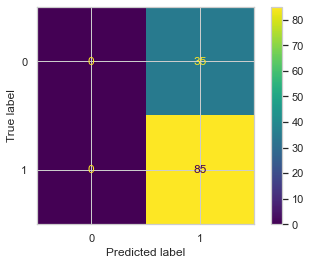

In [39]:
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

RANDOM FOREST

In [40]:
clf = RandomForestClassifier(n_estimators = 25, criterion = 'entropy', random_state =7)
clf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=25, random_state=7)

In [41]:
y_test_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Recall:", recall_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred))
print("F1:", f1_score(y_test, y_test_pred))

Accuracy: 0.8
Recall: 0.9529411764705882
Precision: 0.801980198019802
F1: 0.8709677419354839


CART

In [42]:
clf = DecisionTreeClassifier(criterion='entropy')
clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy')

In [43]:

y_test_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Recall:", recall_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred))
print("F1:", f1_score(y_test, y_test_pred))

Accuracy: 0.7166666666666667
Recall: 0.7764705882352941
Precision: 0.8148148148148148
F1: 0.7951807228915663
